In [63]:
import os
import uuid
import time
import cv2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import json

In [64]:
image_dir = os.path.join('data', 'images')
number_of_images = 30

In [65]:
cap = cv2.VideoCapture(0)
for i in range(number_of_images):
    ret,frame = cap.read()
    imgname = os.path.join(image_dir, f"{str(uuid.uuid1())}.jpg")
    cv2.imwrite(imgname,frame)
    cv2.imshow('image',frame)
    time.sleep(1)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [66]:
!pip install labelme

In [67]:
# load images

images = tf.data.Dataset.list_files(os.path.join(image_dir, '*.jpg'))

In [68]:
def load_image(img):
    byte_img = tf.io.read_file(img)
    print(byte_img)
    img = tf.image.decode_jpeg(byte_img)
    print(img)
    return img

images = images.map(load_image)

Tensor("ReadFile:0", shape=(), dtype=string)
Tensor("DecodeJpeg:0", shape=(None, None, None), dtype=uint8)


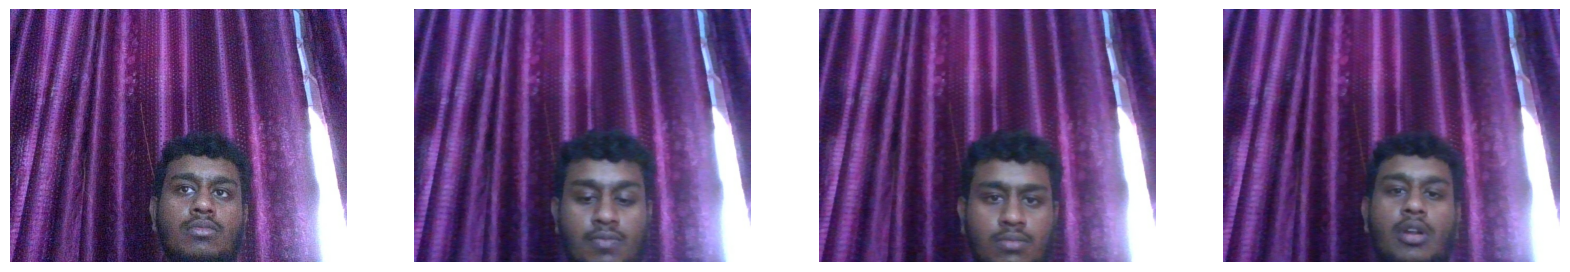

In [69]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()

ax,fig = plt.subplots(ncols=4, figsize=(20,5))
for i in range(4):
    fig[i].imshow(plot_images[i])
    fig[i].axis('off')
plt.show()

In [70]:
!pip install -U albumentations

In [71]:
# move the label to respective train test and val

data_dir = './data'
folders = ['train', 'test', 'val']
existing_labels = os.path.join('data', 'label')

for folder in folders:
    foldername = os.path.join(data_dir, folder)
    label_folder = os.path.join(foldername, 'label')
    os.makedirs(label_folder, exist_ok=True)
    for files in os.listdir(foldername):
        filename = files.split('.')[0]
        print((os.path.join(foldername, "label"+f"{filename}.json")))
        if os.path.exists(os.path.join(foldername, "label,"+f"{filename}.json")):
            print("exosting")
            # move them to label folder in the same folder
            os.replace(os.path.join(foldername, "label,"+f"{filename}.json"), os.path.join(label_folder, f"{filename}.json"))
          

        #     print(os.path.join(existing_labels, f"{filename}.json"))
        #     os.replace(os.path.join(existing_labels, f"{filename}.json"), os.path.join(foldername,'label,' f"{filename}.json"))




./data\train\label113acafa-852f-11ef-af93-c8e2659e55c4.json
./data\train\label11d81a27-852f-11ef-9e6e-c8e2659e55c4.json
./data\train\label12749878-852f-11ef-a79c-c8e2659e55c4.json
./data\train\label1312228c-852f-11ef-b76e-c8e2659e55c4.json
./data\train\label13b26432-852f-11ef-94c2-c8e2659e55c4.json
./data\train\label144e10ac-852f-11ef-bf08-c8e2659e55c4.json
./data\train\label14ea0164-852f-11ef-8e1b-c8e2659e55c4.json
./data\train\label1586432a-852f-11ef-a176-c8e2659e55c4.json
./data\train\label17fb3150-852f-11ef-b5bb-c8e2659e55c4.json
./data\train\label1899b921-852f-11ef-86fe-c8e2659e55c4.json
./data\train\label19d4b2fa-852f-11ef-b42f-c8e2659e55c4.json
./data\train\label1a756f89-852f-11ef-8d08-c8e2659e55c4.json
./data\train\label1b138b37-852f-11ef-8357-c8e2659e55c4.json
./data\train\label1bb16866-852f-11ef-ac40-c8e2659e55c4.json
./data\train\label1c4ed1b2-852f-11ef-b776-c8e2659e55c4.json
./data\train\label1ceac606-852f-11ef-a872-c8e2659e55c4.json
./data\train\label1d881b2b-852f-11ef-924

In [72]:
# albumentations
import albumentations as alb
augmentor = alb.Compose([
    alb.RandomCrop(width=256, height=256),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5),
],
bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))


In [80]:
# Augumentation pipeline

for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join(data_dir, partition)):
        img = cv2.imread(os.path.join(data_dir, partition, image))

        coords = [0,0,0.0001,0.0001]
        label_path = os.path.join(data_dir, partition, 'label', f"{image.split('.')[0]}.json")
        if os.path.exists(label_path):
            with open(label_path) as f:
                label = json.load(f)
                coords[0] = label['shapes'][0]['points'][0][0]
                coords[1] = label['shapes'][0]['points'][0][1]
                coords[2] = label['shapes'][0]['points'][1][0]
                coords[3] = label['shapes'][0]['points'][1][1]
                coords = list(np.divide(coords,[640,480,640,480]))


                try:
                    for x in range(60):
                        augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                        cv2.imwrite(os.path.join('aug_data', partition, 'images',f"{image.split('.')[0]}_{str(x)}.jpg"), augmented['image'])
                        
                        annotaions = {}
                        annotaions['image'] = image

                        if os.path.exists(label_path):
                            if len(augmented['bboxes'])==0:
                                augmented['bboxes'] = [0,0,0,0]
                                augmented['class'] = 0
                            else:
                                augmented['bboxes'] = augmented['bboxes'][0]
                                augmented['class'] = 1
                        else:
                            augmented['bboxes'] = [0,0,0,0]
                            augmented['class'] = 0


                        with open(os.path.join('aug_data', partition, 'labels', f"{image.split('.')[0]}_{str(x)}.json"), 'w') as f:
                            json.dump(annotaions, f)
                except Exception as e:
                    print(f"Error in {image} {e}")

Error in 144e10ac-852f-11ef-bf08-c8e2659e55c4.jpg x_max is less than or equal to x_min for bbox [0.61375344 0.2081044  0.35018888 0.37522894 0.        ].
